In [1]:
# - This script loads the Fake news dataset 
# - It trains multiple traditional ML models (Logistic Regression, Linear SVM, RandomForest,
#   MultinomialNB, XGBoost, Decision Tree, KNN) and reports comparison metrics for binary settings.
# - Adjust hyperparameters or pipeline steps as needed.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bdas2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Load Data

In [3]:
# 2. LOAD DATA
# ============================
df = pd.read_csv("fake_news_dataset.csv")   # change file name if needed
df['label'] = df['label'].map({"fake": 0, "real": 1})

df.head()

,title,text,date,source,author,category,label
0,Foreign Democrat final.,more tax development both store agreement lawy...,2023-03-10,NY Times,Paula George,Politics,1
1,To offer down resource great point.,probably guess western behind likely next inve...,2022-05-25,Fox News,Joseph Hill,Politics,0
2,Himself church myself carry.,them identify forward present success risk sev...,2022-09-01,CNN,Julia Robinson,Business,0
3,You unit its should.,phone which item yard Republican safe where po...,2023-02-07,Reuters,Mr. David Foster DDS,Science,0
4,Billion believe employee summer how.,wonder myself fact difficult course forget exa...,2023-04-03,CNN,Austin Walker,Technology,0


In [4]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     20000 non-null  object
 1   text      20000 non-null  object
 2   date      20000 non-null  object
 3   source    19000 non-null  object
 4   author    19000 non-null  object
 5   category  20000 non-null  object
 6   label     20000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 1.1+ MB
None
title          0
text           0
date           0
source      1000
author      1000
category       0
label          0
dtype: int64


In [5]:
df.shape

(20000, 7)

In [6]:
# Remove duplicate rows
df = df.drop_duplicates()
df = df.dropna(subset=['text'])  # drop rows where text is missing

print("After removing duplicates:", df.shape)

After removing duplicates: (20000, 7)


### 2. EDA

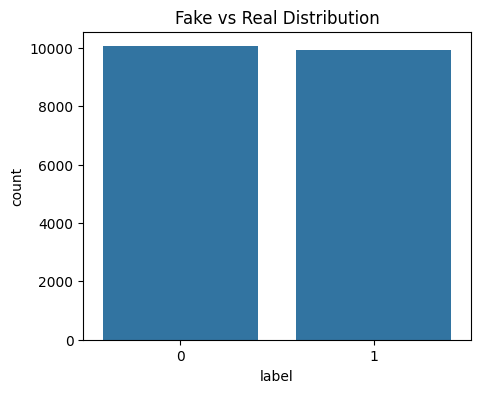

In [7]:
# 3. EDA
# ============================
plt.figure(figsize=(5,4))
sns.countplot(x=df['label'])
plt.title("Fake vs Real Distribution")
plt.show()

In [8]:
print(df['label'].value_counts())

label
0    10056
1     9944
Name: count, dtype: int64


### 3. Text Preprocessing

In [9]:
# 3. TEXT PREPROCESSING
# ============================

def clean_text(text):
    if isinstance(text, float):   # fix float error
        text = ""
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)            # remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)                     # remove numbers
    words = text.split()
    words = [w for w in words if w not in stop_words]   # remove stopwords
    return " ".join(words)

df['clean_text'] = df['text'].apply(clean_text)

In [10]:
df.head()

,title,text,date,source,author,category,label,clean_text
0,Foreign Democrat final.,more tax development both store agreement lawy...,2023-03-10,NY Times,Paula George,Politics,1,tax development store agreement lawyer hear ou...
1,To offer down resource great point.,probably guess western behind likely next inve...,2022-05-25,Fox News,Joseph Hill,Politics,0,probably guess western behind likely next inve...
2,Himself church myself carry.,them identify forward present success risk sev...,2022-09-01,CNN,Julia Robinson,Business,0,identify forward present success risk several ...
3,You unit its should.,phone which item yard Republican safe where po...,2023-02-07,Reuters,Mr. David Foster DDS,Science,0,phone item yard republican safe police identif...
4,Billion believe employee summer how.,wonder myself fact difficult course forget exa...,2023-04-03,CNN,Austin Walker,Technology,0,wonder fact difficult course forget exactly pa...


### 4. TRAIN-TEST SPLIT

In [11]:
# 4. TRAIN-TEST SPLIT
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42
)

### 5. TF-IDF VECTORIZATION

In [12]:
# 5. TF-IDF VECTORIZATION
# ============================
tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

### 6. MODEL TRAINING

In [13]:
# 6. MODEL TRAINING
# ============================
from sklearn.metrics import accuracy_score, classification_report, f1_score
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "Multinomial NB": MultinomialNB(),
    "SVM": LinearSVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier()
}

results = {"Model": [], "Accuracy": [], "F1 Score": []}

for name, model in models.items():
    print(f"\n========== Training {name} ==========\n")
    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="weighted")

    results["Model"].append(name)
    results["Accuracy"].append(acc)
    results["F1 Score"].append(f1)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_test, preds))


========== Training Logistic Regression ==========

Accuracy: 0.5082
F1 Score: 0.5083
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      2029
           1       0.50      0.50      0.50      1971

    accuracy                           0.51      4000
   macro avg       0.51      0.51      0.51      4000
weighted avg       0.51      0.51      0.51      4000


========== Training Random Forest ==========

Accuracy: 0.5090
F1 Score: 0.5078
              precision    recall  f1-score   support

           0       0.51      0.56      0.54      2029
           1       0.50      0.46      0.48      1971

    accuracy                           0.51      4000
   macro avg       0.51      0.51      0.51      4000
weighted avg       0.51      0.51      0.51      4000


========== Training XGBoost ==========

Accuracy: 0.4960
F1 Score: 0.4958
              precision    recall  f1-score   support

           0       0.50      0.47      0.49     

C:\Users\bdas2\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.5028
F1 Score: 0.5027
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2029
           1       0.50      0.49      0.49      1971

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.50      4000
weighted avg       0.50      0.50      0.50      4000


========== Training Decision Tree ==========

Accuracy: 0.4905
F1 Score: 0.4905
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2029
           1       0.48      0.48      0.48      1971

    accuracy                           0.49      4000
   macro avg       0.49      0.49      0.49      4000
weighted avg       0.49      0.49      0.49      4000


========== Training KNN ==========

Accuracy: 0.5038
F1 Score: 0.5037
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2029
           1       0.50      0.49      0.50      19

### 7. RESULTS COMPARISON TABLE

In [14]:
# 8. RESULTS COMPARISON TABLE
# ============================
comparison_df = pd.DataFrame(results)
print("\n\n========== MODEL COMPARISON ==========\n")
print(comparison_df.sort_values(by="Accuracy", ascending=False))



========== MODEL COMPARISON ==========

                 Model  Accuracy  F1 Score
3       Multinomial NB   0.51525  0.510855
1        Random Forest   0.50900  0.507807
0  Logistic Regression   0.50825  0.508255
6                  KNN   0.50375  0.503726
4                  SVM   0.50275  0.502705
2              XGBoost   0.49600  0.495754
5        Decision Tree   0.49050  0.490478


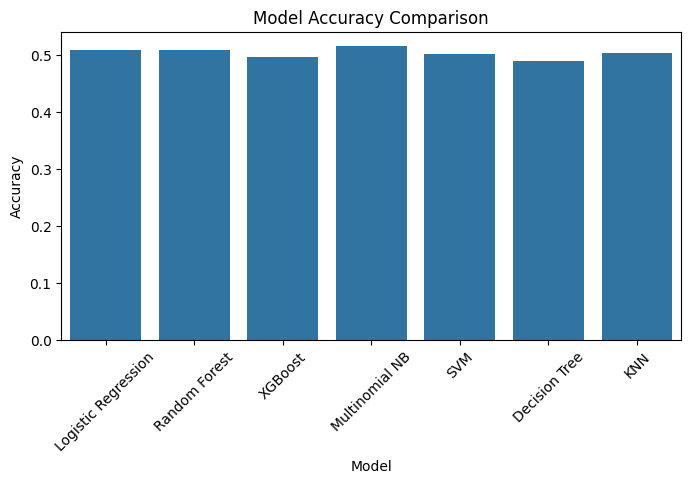

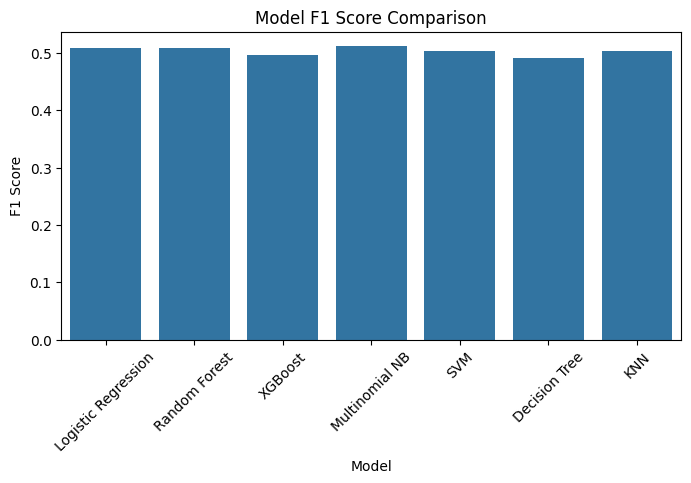

In [15]:
# 9. BAR CHART OF RESULTS
# ============================
plt.figure(figsize=(8,4))
sns.barplot(x="Model", y="Accuracy", data=comparison_df)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x="Model", y="F1 Score", data=comparison_df)
plt.title("Model F1 Score Comparison")
plt.xticks(rotation=45)
plt.show()